In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
path = "C:/Users/arinj/OneDrive/Desktop/YOLOW/train"
annot = "C:/Users/arinj/OneDrive/Desktop/YOLOW/train_anotations"

Bike_1.jpg


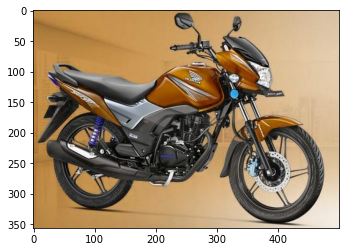

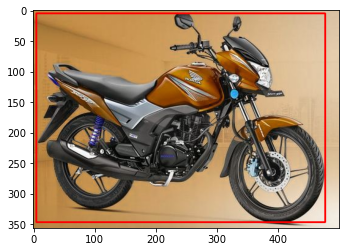

In [3]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

In [4]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()

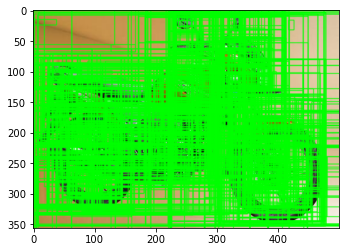

In [5]:
im = cv2.imread(os.path.join(path,"Bike_1.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [6]:
train_images=[]
train_labels=[]

In [7]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [8]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [9]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("Bike"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 Bike_1.jpg
1 Bike_10.jpg
2 Bike_11.jpg
3 Bike_12.jpg
4 Bike_13.jpg
5 Bike_14.jpg
6 Bike_15.jpg
7 Bike_16.jpg
8 Bike_17.jpg
9 Bike_18.jpg
10 Bike_19.jpg
11 Bike_2.jpg
12 Bike_20.jpg
13 Bike_22.jpg
14 Bike_23.jpg
15 Bike_24.jpg
16 Bike_25.jpg
17 Bike_26.jpg
18 Bike_27.jpg
19 Bike_28.jpg
20 Bike_29.jpg
21 Bike_3.jpg
22 Bike_30.jpg
23 Bike_4.jpg
24 Bike_5.jpg
25 Bike_6.jpg
26 Bike_7.jpg
27 Bike_8.jpg
OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

error in Bike_8.jpg
28 Bike_9.jpg


In [10]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [11]:
X_new.shape

(1236, 224, 224, 3)

In [12]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [13]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [15]:
X= vggmodel.layers[-2].output

In [16]:
predictions = Dense(2, activation="softmax")(X)

In [17]:
model_final = Model(inputs=vggmodel.input, outputs=predictions)

In [18]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001)

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [20]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [22]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [23]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [24]:
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [25]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1112, 224, 224, 3) (124, 224, 224, 3) (1112, 2) (124, 2)


In [26]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [28]:
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [29]:
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 5, epochs= 6, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

C:\Users\arinj\AppData\Local\Temp/ipykernel_12904/1973598210.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 5, epochs= 6, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])


Epoch 1/6
5/5 [==============================] - ETA: 0s - loss: 1.2813 - accuracy: 0.7688 
Epoch 1: val_loss improved from inf to 0.08487, saving model to ieeercnn_vgg16_1.h5
5/5 [==============================] - 152s 30s/step - loss: 1.2813 - accuracy: 0.7688 - val_loss: 0.0849 - val_accuracy: 0.9688
Epoch 2/6
5/5 [==============================] - ETA: 0s - loss: 0.2276 - accuracy: 0.9563 
Epoch 2: val_loss improved from 0.08487 to 0.01792, saving model to ieeercnn_vgg16_1.h5
5/5 [==============================] - 117s 25s/step - loss: 0.2276 - accuracy: 0.9563 - val_loss: 0.0179 - val_accuracy: 1.0000
Epoch 3/6
5/5 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9812 
Epoch 3: val_loss improved from 0.01792 to 0.00281, saving model to ieeercnn_vgg16_1.h5
5/5 [==============================] - 121s 26s/step - loss: 0.0668 - accuracy: 0.9812 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 4/6
5/5 [==============================] - ETA: 0s - loss: 0.0490 - acc

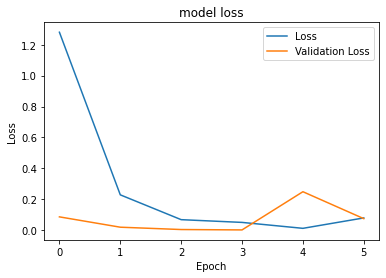

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

1/1 [==============================] - 0s 470ms/step
Bike


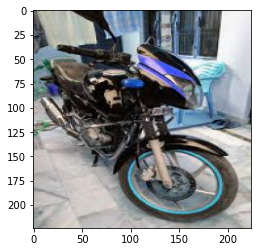

In [36]:
im = X_test[1]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("Bike")
else:
    print("not Bike")

In [ ]:
image = cv2.imread(os.path.join(path,'Bike_1.jpg'))
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

imOut = image.copy()
boxes = []
count = 0
for e,result in enumerate(ssresults):
    if e < 50:
        x,y,w,h = result
        timage = imout[x:x+w,y:y+h]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        resized = np.expand_dims(resized,axis = 0)
        out = final_model.predict(resized)
        print(e,out)
        if(out[0][0]